# Numpyro implementation of the (univariate) Von Mises distribution

In [1]:
import jax
import jax.numpy as np
import jax.random as random
import numpy as onp
import math

from jax.scipy.special import gammaln
from numpyro.distributions import constraints
from numpyro.distributions.distribution import Distribution
from numpyro.distributions.util import lazy_property
from numpyro.util import copy_docs_from
from jax.scipy.special import logsumexp
from jax import jit, lax
from functools import partial
from numpyro.distributions.util import (
    cholesky_of_inverse,
    cumsum,
    lazy_property,
    matrix_to_tril_vec,
    promote_shapes,
    signed_stick_breaking_tril,
    validate_sample,
    vec_to_tril_matrix
)

_I0_COEF_SMALL = [1.0, 3.5156229, 3.0899424, 1.2067492, 0.2659732, 0.360768e-1, 0.45813e-2]
_I0_COEF_LARGE = [0.39894228, 0.1328592e-1, 0.225319e-2, -0.157565e-2, 0.916281e-2,
                  -0.2057706e-1, 0.2635537e-1, -0.1647633e-1, 0.392377e-2]
_I1_COEF_SMALL = [0.5, 0.87890594, 0.51498869, 0.15084934, 0.2658733e-1, 0.301532e-2, 0.32411e-3]
_I1_COEF_LARGE = [0.39894228, -0.3988024e-1, -0.362018e-2, 0.163801e-2, -0.1031555e-1,
                  0.2282967e-1, -0.2895312e-1, 0.1787654e-1, -0.420059e-2]

_COEF_SMALL = [_I0_COEF_SMALL, _I1_COEF_SMALL]
_COEF_LARGE = [_I0_COEF_LARGE, _I1_COEF_LARGE]

def _log_modified_bessel_fn(x, order=0):
    """
    Returns ``log(I_order(x))`` for ``x > 0``,
    where `order` is either 0 or 1.
    """
    assert order == 0 or order == 1

    # compute small solution
    y = (x / 3.75)
    y = y * y
    small = _eval_poly(y, _COEF_SMALL[order])
    
    if order == 1:
        small = abs(x) * small
    small = np.log(small)

    # compute large solution
    y = 3.75 / x
    large = x - 0.5 * np.log(x) + np.log(_eval_poly(y, _COEF_LARGE[order]))

    result = np.where(x < 3.75, small, large)
    return result

def _eval_poly(y, coef):
    coef = list(coef)
    result = coef.pop()
    while coef:
        result = coef.pop() + y * result
    return result

def condition(args):
    return ~np.all(args[2])

def loop(args):
    x, proposal_r, done, key, concentration = args
    key, subkey = jax.random.split(key)
    u = jax.random.uniform(subkey, shape = (3,) + x.shape)
    u1, u2, u3 = u.squeeze()
    z = np.cos(math.pi * u1)
    f = (1 + proposal_r * z) / (proposal_r + z)
    c = concentration * (proposal_r - f)
    accept = ((c * (2 - c) - u2) > 0) | (np.log(c / u2) + 1 - c >= 0)
    x = np.where(accept, np.sign(u3 - 0.5) * np.arccos(f),  x)          
    done = done | accept
    return x, proposal_r, done, key, concentration

def _rejection_sample(loc, concentration, proposal_r, key, x):
    done = np.zeros(x.shape, dtype=bool)
    x = lax.while_loop(condition, loop, (x, proposal_r, done, key, concentration))[0]
    return (x + math.pi + loc) % (2 * math.pi) - math.pi
    
@copy_docs_from(Distribution)
class VonMises(Distribution):
    """
    A circular von Mises distribution.

    This implementation uses polar coordinates. The ``loc`` and ``value`` args
    can be any real number (to facilitate unconstrained optimization), but are
    interpreted as angles modulo 2 pi.

    :param int: an angle in radians.
    :param int: concentration parameter
    
    """
    arg_constraints = {'loc': constraints.real, 'concentration': constraints.positive}
    support = constraints.real
    has_rsample = False
    
    def __repr__(self):
        return str(type(self).__name__) + "(loc: " + str(self.loc) + ", concentration: " + str(self.concentration) + ")"

    def __init__(self, loc, concentration, validate_args=None):
        self.loc, self.concentration = promote_shapes(loc, concentration)
        batch_shape = lax.broadcast_shapes(np.shape(loc), np.shape(concentration))
        event_shape = ()

        # Parameters for sampling
        tau = 1 + np.sqrt(1 + 4 * self.concentration ** 2)
        rho = (tau - np.sqrt(2 * tau)) / (2 * self.concentration)
        self._proposal_r = (1 + rho ** 2) / (2 * rho)
        
        super(VonMises, self).__init__(batch_shape, event_shape, validate_args)

    def log_prob(self, value):
        log_prob = self.concentration * np.cos(value - self.loc)
        log_prob = log_prob - math.log(2 * math.pi) - _log_modified_bessel_fn(self.concentration, order=0)
        return log_prob
    
    def sample(self, key, sample_shape = ()):
        """
        The sampling algorithm for the von Mises distribution is based on the following paper:
        Best, D. J., and Nicholas I. Fisher.
        "Efficient simulation of the von Mises distribution." Applied Statistics (1979): 152-157.
        """
        if isinstance(sample_shape, int):
            shape = tuple([sample_shape]) + self.batch_shape + self.event_shape
        else:
            shape = sample_shape + self.batch_shape + self.event_shape
            
        x = np.empty(shape)            
        return _rejection_sample(self.loc, self.concentration, self._proposal_r, key, x)

    def expand(self, batch_shape):
        validate_args = self.__dict__.get('_validate_args')
        loc = np.ones(batch_shape)*self.loc
        concentration = np.ones(batch_shape)*self.concentration
        return VonMises(loc, concentration, validate_args=validate_args)

    @property
    def mean(self):
        """
        The provided mean is the circular one.
        """
        return self.loc

    @lazy_property
    def variance(self):
        """
        The provided variance is the circular one.
        """
        return 1 - np.exp(_log_modified_bessel_fn(self.concentration, order=1) -
                    _log_modified_bessel_fn(self.concentration, order=0))


In [2]:
#Example on use
rng_key = random.PRNGKey(1)
example = VonMises(0, 4)
n = 10000000
print(example, "\n")
print("Sampling {} values: \n".format(n), example.sample(rng_key, n), "\n")
print("Mean: ", example.mean)
print("Variance: ", example.variance)
print("Log-prob: ", example.log_prob(1))

VonMises(loc: 0, concentration: 4) 

Sampling 10000000 values: 
 [ 0.43092918  0.7343147   0.06427526 ...  0.3453114   0.2717576
 -0.02171373] 

Mean:  0
Variance:  0.13647735
Log-prob:  -2.1016407


## Comparing runtime, torch.distribution.VonMises vs. Numpyro

In [3]:
import time
import torch
from torch.distributions import VonMises as vm

example = VonMises(0, 4)
rng_key = random.PRNGKey(1)

#My Numpyro implementation
start = time.time()
print(len(example.sample(rng_key, 1000000)))
end = time.time()
print("Generating 1000000 samples, Numpyro implementation: ", end - start)

#Torch distribution
d = vm(torch.tensor(0.5), torch.tensor(0.5))
start = time.time()
d.sample(torch.Size([1000000]))
end = time.time()
print("Torch distribution run time for 1000000 samples: ", end - start)

1000000
Generating 1000000 samples, Numpyro implementation:  1.244018793106079
Torch distribution run time for 1000000 samples:  0.8346021175384521


## Plotting the distribution 

Sanity check whether the sampling process follows the actual pdf. 

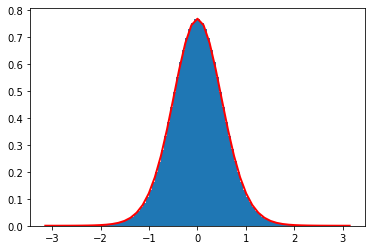

In [7]:
import matplotlib.pyplot as plt
from scipy.special import i0
mu, kappa = 0.0, 4.0 # mean and dispersion
test = example.sample(rng_key, 10000000)
x = np.linspace(-np.pi, np.pi, num=51)
y = np.exp(kappa*np.cos(x-0))/(2*np.pi*i0(4))
plt.hist(test, 100, density=True)
plt.plot(x, y, linewidth=2, color='r')
plt.show()

## Comparing results from torch.distributions.VonMises and making sure that the output dimensions are correct

In [5]:
d = vm(torch.tensor(0.5), torch.tensor(0.5))
print(d.batch_shape)
print(d.event_shape)
x = d.sample()
print(x.shape)
print(d.log_prob(x).shape)
print(d.log_prob(3))
print(x)

torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
tensor(-2.3000)
tensor(-0.6758)


In [6]:
d = VonMises(0.5, 0.5)
print(d.batch_shape)
print(d.event_shape)
x = d.sample(rng_key)
print(x.shape)
print(d.log_prob(x).shape)
print(d.log_prob(3))
print(x)

()
()
()
()
-2.2999985
-0.6729262
